# Ringer Shape

In [1]:
import collections
import gzip
import os
import time
import matplotlib
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tqdm
import mplhep as hep
import atlas_mpl_style as ampl
ampl.use_atlas_style()
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
os.makedirs("output",exist_ok=True)

In [2]:
etbins     = [15, 20, 30, 40, 50, 1000000]
etabins    = [0.0, 0.8, 1.37, 1.54, 2.37, 2.50]
references = ['tight_cutbased', 'medium_cutbased' , 'loose_cutbased', 'vloose_cutbased']
model_path = '/mnt/cern_data/joao.pinto/tunings/releases/Run2_20170505_v6/models'
model_path+='/mc15_13TeV.361106_Zee.423300_perf_JF17.25bins.ElectronVeryLoose.Run2_v6.et{ET}_eta{ETA}.h5'

In [3]:
def read_data( file_name ):
    d = dict(np.load(file_name))
    features = d['features'].tolist()
    target = d['target']
    data = d['data']
    data_df = pd.DataFrame({name:data[:,idx] for idx,name in enumerate(features)})
    data_df["target"] = target
    return data_df

def get_data( path ):
    def norm1( data ):
        norms = np.abs( data.sum(axis=1) )
        norms[norms==0] = 1
        return data/norms[:,None]
    d = read_data(path)
    feature_names = d['features'].tolist()
    # How many events?
    n = d['data'].shape[0]
    # extract rings
    data_rings = norm1(d['data'][:,1:101])
    target = d['target']
    avgmu = d['data'][:,0]
    return [data_rings], target, avgmu

In [4]:
et_bin = 5
eta_bin = 0
data_basepath = '/mnt/cern_data/joao.pinto'
data_file_name = f"{data_basepath}/files/mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17/mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17_et{et_bin-3}_eta{eta_bin}.npz"
data = read_data(data_file_name)

In [5]:
data.head()

,avgmu,L2Calo_ring_0,L2Calo_ring_1,L2Calo_ring_2,L2Calo_ring_3,L2Calo_ring_4,L2Calo_ring_5,L2Calo_ring_6,L2Calo_ring_7,L2Calo_ring_8,...,eeMass,el_lhtight,el_lhmedium,el_lhloose,el_lhvloose,T0HLTElectronT2CaloTight,T0HLTElectronT2CaloMedium,T0HLTElectronT2CaloLoose,T0HLTElectronT2CaloVLoose,target
0,36.0,767.492859,-0.472072,-361.322906,-566.061462,-44.995815,-290.825470,-330.343048,82.031937,4338.279785,...,1.0,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1
1,35.0,3193.005615,507.466522,-117.344635,123.058914,-466.772736,-199.998657,-227.583694,-305.141785,4564.270020,...,1.0,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1
2,32.0,1242.509766,235.931381,-946.631104,-163.778656,-293.556519,121.769760,402.875458,151.547943,4666.197266,...,1.0,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1
3,32.0,1177.818115,1213.914551,280.930267,56.904209,224.553268,-195.941803,223.152023,-188.977600,3581.760254,...,1.0,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1
4,31.0,1174.903687,463.270630,270.546570,425.828461,-365.683044,-49.664135,41.832600,196.151901,3409.914062,...,1.0,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1


In [6]:
ring_names = [f"L2Calo_ring_{idx}" for idx in range(100)]
signal_rings = data.loc[data.target==1][ring_names].values
print(signal_rings.shape)
background_rings = data.loc[data.target==0][ring_names].values
print(background_rings.shape)

(87257, 100)
(34622, 100)


In [7]:
signal_ring_means = signal_rings.mean(axis=0)
print(signal_ring_means.shape)
background_ring_means = background_rings.mean(axis=0)
print(background_ring_means.shape)

(100,)
(100,)


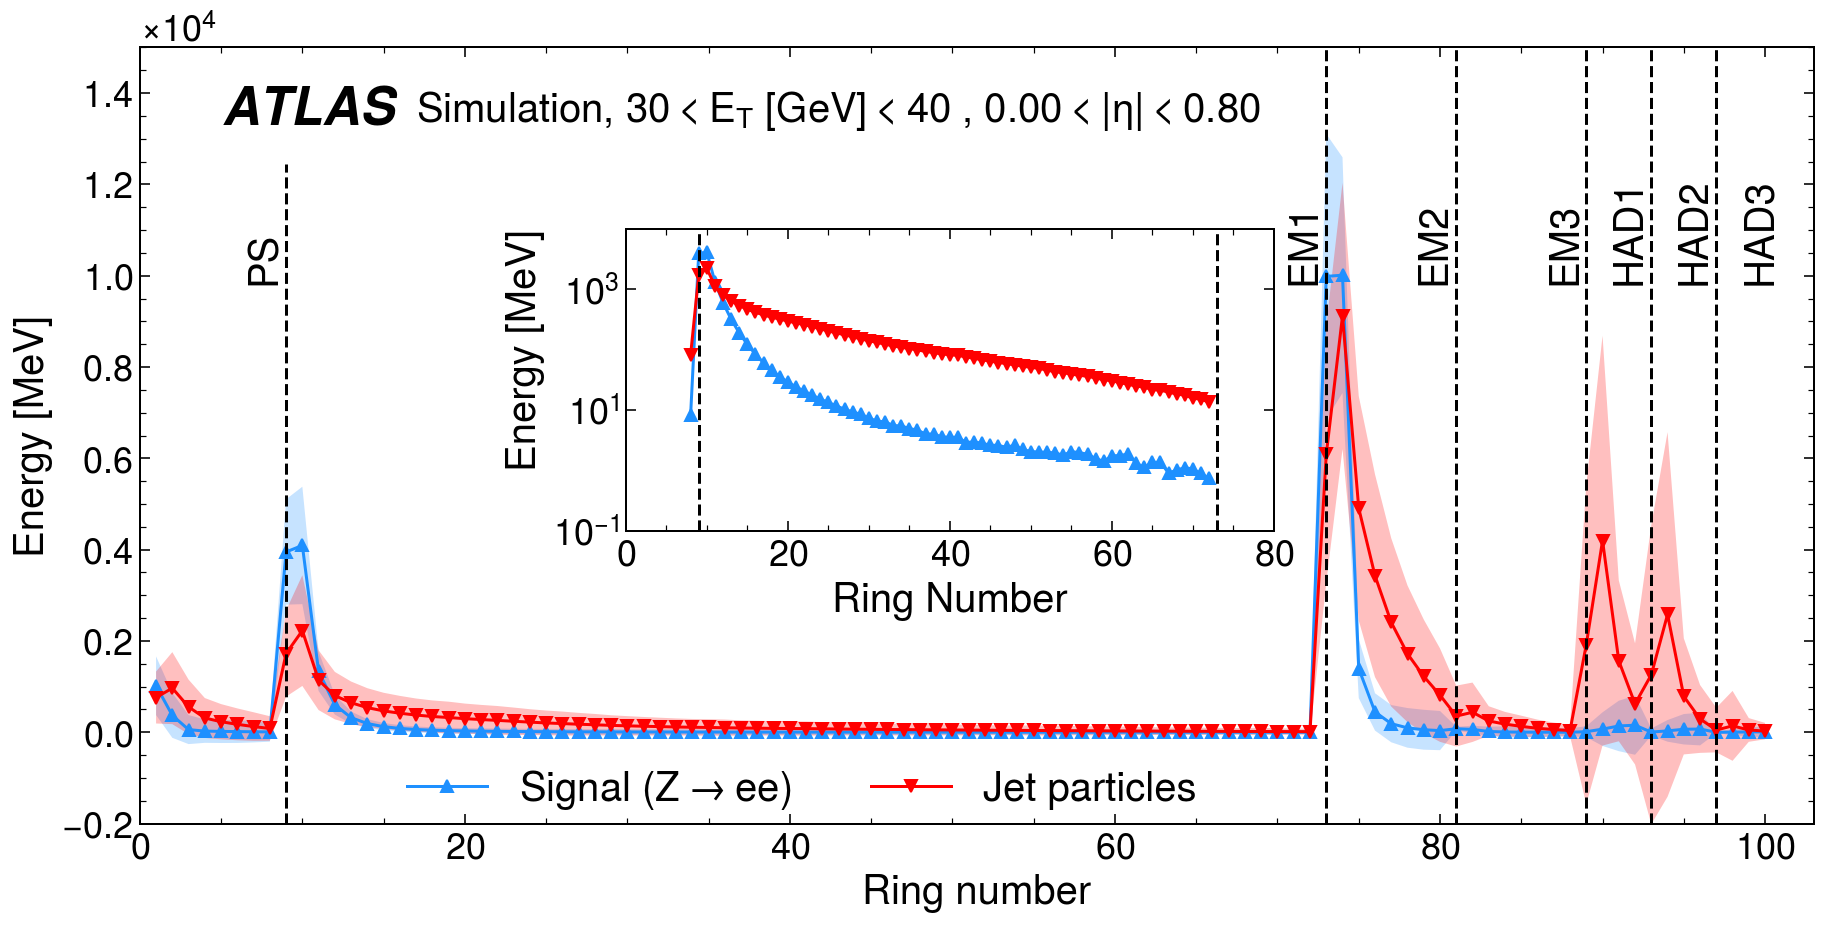

In [14]:
plt.rcParams['text.usetex'] = False
rings = [f"L2Calo_ring_{idx}" for idx in range(100)]
fig, ax = plt.subplots(figsize=(15, 7))

df1     = data.loc[data.target==1]
df2     = data.loc[data.target==0]
data1   = df1[rings].values.astype(np.float32)
data2   = df2[rings].values.astype(np.float32)
d1_mean = np.mean(data1, axis=0)
d1_std  = np.std(data1 , axis=0)
d2_mean = np.mean(data2, axis=0)
d2_std  = np.std(data2 , axis=0)
y_label = r'Energy [MeV]'

n_rings     = [8, 64, 8, 8, 4, 4, 4]
layer_names = ['PS', 'EM1', 'EM2', 'EM3', 'HAD1', 'HAD2', 'HAD3']
    
# plot signal
g1, = ax.plot(range(1, 101), d1_mean, color='dodgerblue', label=r'Signal (Z$\rightarrow$ee)', marker='^')
ax.fill_between(range(1, 101), d1_mean - d1_std, d1_mean + d1_std,
                    facecolor='dodgerblue', alpha=0.25)

# plot signal
g2, = ax.plot(range(1, 101), d2_mean, color='red', label='Jet particles', marker='v')
ax.fill_between(range(1, 101), d2_mean - d2_std, d2_mean + d2_std,
                    facecolor='red', alpha=0.25)
    
counter = 1
for idx, (i_ring, i_layer) in enumerate(zip(n_rings, layer_names)):
    counter += i_ring
    if counter < 100:
        if i_layer=="PS":
            ax.axvline(x=counter, ymax=0.85, ls='--', lw=1.5, color='black')
        else:
            ax.axvline(x=counter, ls='--', lw=1.5, color='black')

    ax.text(counter - 2.5, y=d1_mean.max(), s=i_layer, rotation=90, fontsize=20)
    
#ymin, ymax = plt.gca().get_ylim()
#ax.text(5, 1.15*10000, "30 < E_T [GeV] < 40, 0.00 < |\eta| < 0.80", fontsize=20)


ymin, ymax = plt.gca().get_ylim()
# set new ymax 
ax.set_ylim([ymin, 1.4*ymax])
# add a zoom into the profile
ax2 = plt.axes([.35, .4, .3, .3])
zoom_rings = ['L2Calo_ring_%i' %iring for iring in range(7, 7+64+1)]
ax2.semilogy(range(8, 8+64+1), d1_mean[range(7, 7+64+1)], color='dodgerblue', label='electron', marker='^')
ax2.semilogy(range(8, 8+64+1), d2_mean[range(7, 7+64+1)], color='red', label='jet', marker='v')
counter = 1
for idx, (i_ring, i_layer) in enumerate(zip([8, 64], ['PS', 'EM1'])):
    counter += i_ring
    if counter != 100:
        ax2.axvline(x=counter, ls='--', lw=1.5, color='black')
ax2.set_xlabel("Ring Number")


ax.legend(handles=[g1,g2], fontsize=20,ncol=2, loc=(0.15,-0.005))
ax.set_ylabel(y_label)
ax.set_xlabel('Ring number')
ax.set_xlim([0, 103])
ax.set_ylim([-0.2*10000,1.5*10000])
#ax.set_yscale('log')
hep.atlas.text(r" Simulation, $30 < E_T $ [GeV]$ < 40$ , $0.00 < |\eta| < 0.80$", ax=ax, loc=1, fontsize=20)
ampl.set_ylabel(y_label)
#ax.grid()
#fig.suptitle(plot_title)
#ax.tight_layout()
plt.savefig("output/ring_shape.pdf", facecolor='white')
#plt.close()